# Pylops - seismic inversion for reflectivity

### Author: M.Ravasi

In this notebook I will show how to perform seismic inversion for reflectivity (also sometimes called spiky deconvolution)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse.linalg import lsqr
from scipy.signal import filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity import *

## Reflectivity inversion - 2D

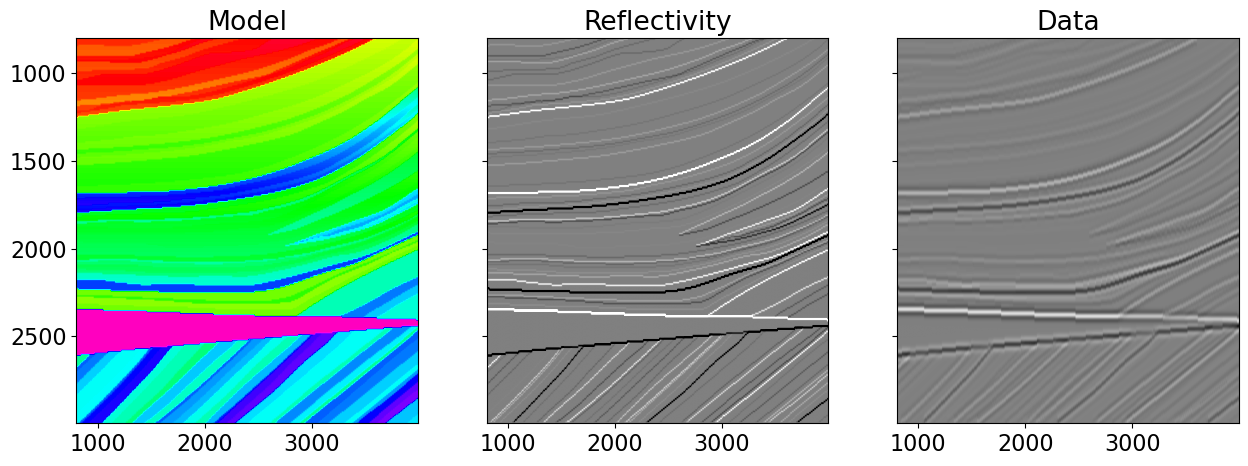

In [ ]:
# Load model
inputfile='../data/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, m = model['x'], model['z'], np.log(model['model']).T
nx, nz = len(x), len(z)

# Wavelet 
dt = 0.004
ntwav = 41
wav, tw, wavc = ricker(np.arange(ntwav//2+1) * dt, 15)

# Operators
Dop = FirstDerivative((nx, nz), axis=-1)
Cop = Convolve1D((nx, nz), wav, offset=wavc)

# Data
r = Dop @ m
d = Cop @ r

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
axs[0].imshow(m.T, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(r.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-.1, vmax=.1)
axs[1].set_title('Reflectivity')
axs[1].axis('tight')
axs[2].imshow(d.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[2].set_title('Data')
axs[2].axis('tight');

Different inversion choices

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 440000 rows and 440000 cols
eps = 1.000000e-02	tol = 1.000000e-08	niter = 400
alpha = 2.091076e-02	thresh = 1.045538e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -5.4322e-04         4.476e+02   4.856e+02   9.261e+00
     2      -8.2294e-04         2.275e+02   2.713e+02   2.439e+00
     3      -6.8818e-04         1.336e+02   1.812e+02   1.762e+00
     4      -2.7977e-04         8.565e+01   1.358e+02   1.390e+00
     5       0.0000e+00         5.823e+01   1.100e+02   1.153e+00
     6       1.0014e-04         4.145e+01   9.442e+01   9.809e-01
     7       5.3695e-05         3.063e+01   8.445e+01   8.493e-01
     8       0.0000e+00         2.330e+01   7.764e+01   7.474e-01
     9      -0.0000e+00         1.814e+01   7.278e+01   6.666e-01
    10      

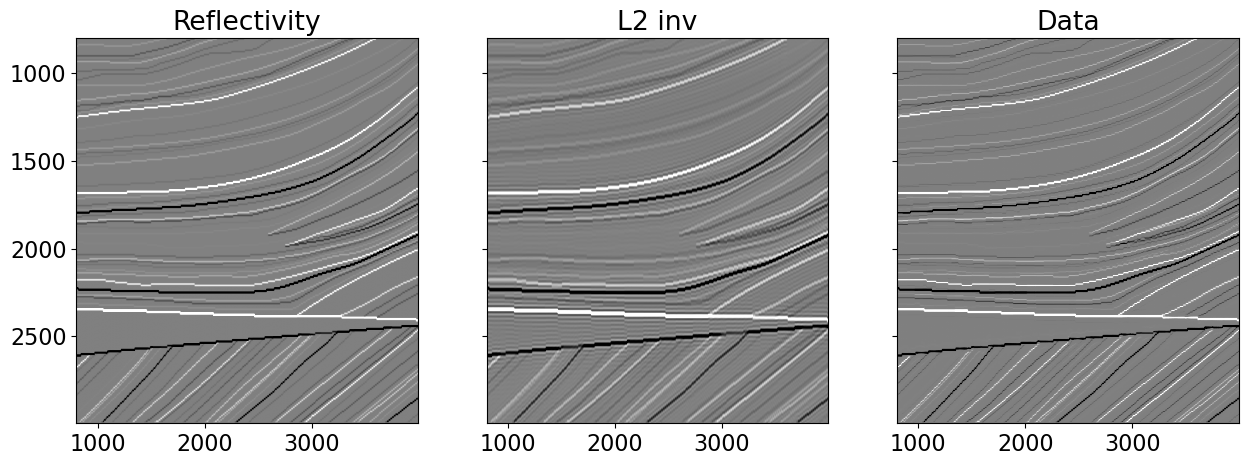

In [ ]:
# L2 inversion
D2op  = Laplacian([nx, nz], dtype='float64')

rl2 = normal_equations_inversion(Cop, d.ravel(), [D2op], 
                                 epsRs=[np.sqrt(1e-4)],
                                 **dict(maxiter=100))[0]
rl2 = rl2.reshape(nx, nz)

# Sparse inversion
rfista, _, resfista = fista(Cop, d.ravel(), niter=400, eps=1e-2, tol=1e-8, show=True)
rfista = rfista.reshape(nx, nz)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
axs[0].imshow(r.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-.1, vmax=.1)
axs[0].set_title('Reflectivity')
axs[0].axis('tight')
axs[1].imshow(rl2.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-.1, vmax=.1)
axs[1].set_title('L2 inv')
axs[1].axis('tight')
axs[2].imshow(rfista.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-.1, vmax=.1)
axs[2].set_title('Data')
axs[2].axis('tight');